# Regression Tabular Model for Kaggle Playground Series Season 3 Episode 6 Using Python and Scikit-Learn
### David Lowe
### March 13, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 6 Dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Paris Housing Price Prediction dataset. Feature distributions are close to but different from the original.

ANALYSIS: The average performance of the machine learning algorithms achieved an RMSE benchmark of 454,623 after preliminary training runs. Furthermore, we selected Random Forest Regressor as the final model as it processed the training dataset with an RMSE score of 133,540. When we tested the final model using the test dataset, the model achieved an RMSE score of 225,268.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 6

Dataset ML Model: Regression with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e6/

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e6/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import datasets

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'price'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'neg_root_mean_squared_error'

# Define the directory locations and file names
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e06/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e06/test.csv'
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e06/ParisHousing.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e06/sample_submission.csv'
SUBMISSION_FILE = 'submission_sklearn_'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0   0         34291             24        1        0      47     35693   
1   1         95145             60        0        1      60     34773   
2   2         92661             45        1        1      62     45457   
3   3         97184             99        0        0      59     15113   
4   4         61752            100        0        0      57     64245   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              2              1  2000           0                  1   
1              1              4  2000           0                  1   
2              4              8  2020           1                  1   
3              1              1  2000           0                  1   
4              8              4  2018           1                  0   

   basement  attic  garage  hasStorageRoom  hasGuestRoom      price  
0         8   5196     369               0          

In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [9]:
print(df_dataset_import.describe())

                 id  squareMeters  numberOfRooms       hasYard       hasPool  \
count  22730.000000  2.273000e+04   22730.000000  22730.000000  22730.000000   
mean   11364.500000  4.658622e+04      48.241091      0.475891      0.452750   
std     6561.730145  4.952124e+04      28.226428      0.499429      0.497773   
min        0.000000  8.900000e+01       1.000000      0.000000      0.000000   
25%     5682.250000  2.039275e+04      25.000000      0.000000      0.000000   
50%    11364.500000  4.448400e+04      47.000000      0.000000      0.000000   
75%    17046.750000  7.154700e+04      75.000000      1.000000      1.000000   
max    22729.000000  6.071330e+06     100.000000      1.000000      1.000000   

             floors       cityCode  cityPartRange  numPrevOwners  \
count  22730.000000   22730.000000   22730.000000   22730.000000   
mean      47.305983   50013.795996       5.585042       5.620766   
std       47.777207   30006.637729       2.739533       2.713026   
min    

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.drop(columns=['cityCode'], inplace=True)
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

   squareMeters  numberOfRooms  hasYard  hasPool  floors  cityPartRange  \
0         75523              3        0        1      63              3   
1         80771             39        1        1      98              8   
2         55712             58        0        1      19              6   
3         32316             47        0        0       6             10   
4         70429             19        1        1      90              3   

   numPrevOwners  made  isNewBuilt  hasStormProtector  basement  attic  \
0              8  2005           0                  1      4313   9005   
1              6  2015           1                  0      3653   2436   
2              8  2021           0                  0      2937   8852   
3              4  2012           0                  1       659   7141   
4              7  1990           1                  0      8435   2429   

   garage  hasStorageRoom  hasGuestRoom      price  is_synthetic  
0     956               0            

In [12]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1
df_dataset_import.drop(columns=['id','cityCode'], inplace=True)
df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

# Eliminate obvious outliers in dataset
df_dataset_import.drop(df_dataset_import[df_dataset_import.squareMeters > 100000].index, inplace=True)
df_dataset_import.drop(df_dataset_import[df_dataset_import.floors > 100].index, inplace=True)
df_dataset_import.drop(df_dataset_import[df_dataset_import.made > 2021].index, inplace=True)
df_dataset_import.drop(df_dataset_import[df_dataset_import.attic > 40000].index, inplace=True)
df_dataset_import.drop(df_dataset_import[df_dataset_import.garage > 1000].index, inplace=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32715 entries, 0 to 32729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       32715 non-null  int64  
 1   numberOfRooms      32715 non-null  int64  
 2   hasYard            32715 non-null  int64  
 3   hasPool            32715 non-null  int64  
 4   floors             32715 non-null  int64  
 5   cityPartRange      32715 non-null  int64  
 6   numPrevOwners      32715 non-null  int64  
 7   made               32715 non-null  int64  
 8   isNewBuilt         32715 non-null  int64  
 9   hasStormProtector  32715 non-null  int64  
 10  basement           32715 non-null  int64  
 11  attic              32715 non-null  int64  
 12  garage             32715 non-null  int64  
 13  hasStorageRoom     32715 non-null  int64  
 14  hasGuestRoom       32715 non-null  int64  
 15  price              32715 non-null  float64
 16  is_synthetic       327

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   squareMeters  numberOfRooms  hasYard  hasPool  floors  cityPartRange  \
0         34291             24        1        0      47              2   
1         95145             60        0        1      60              1   
2         92661             45        1        1      62              4   
3         97184             99        0        0      59              1   
4         61752            100        0        0      57              8   

   numPrevOwners  made  isNewBuilt  hasStormProtector  basement  attic  \
0              1  2000           0                  1         8   5196   
1              4  2000           0                  1       729   4496   
2              8  2020           1                  1      7473   8953   
3              1  2000           0                  1      6424   8522   
4              4  2018           1                  0      7151   2786   

   garage  hasStorageRoom  hasGuestRoom     target  is_synthetic  
0     369               0            

In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32715 entries, 0 to 32729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       32715 non-null  int64  
 1   numberOfRooms      32715 non-null  int64  
 2   hasYard            32715 non-null  int64  
 3   hasPool            32715 non-null  int64  
 4   floors             32715 non-null  int64  
 5   cityPartRange      32715 non-null  int64  
 6   numPrevOwners      32715 non-null  int64  
 7   made               32715 non-null  int64  
 8   isNewBuilt         32715 non-null  int64  
 9   hasStormProtector  32715 non-null  int64  
 10  basement           32715 non-null  int64  
 11  attic              32715 non-null  int64  
 12  garage             32715 non-null  int64  
 13  hasStorageRoom     32715 non-null  int64  
 14  hasGuestRoom       32715 non-null  int64  
 15  target             32715 non-null  float64
 16  is_synthetic       327

In [15]:
print(df_dataset_import.describe())

       squareMeters  numberOfRooms       hasYard       hasPool        floors  \
count  32715.000000   32715.000000  32715.000000  32715.000000  32715.000000   
mean   47397.018646      48.882072      0.486077      0.466269     48.027327   
std    29144.389989      28.426204      0.499814      0.498869     27.562605   
min       89.000000       1.000000      0.000000      0.000000      1.000000   
25%    21581.000000      25.000000      0.000000      0.000000     25.000000   
50%    46131.000000      48.000000      0.000000      0.000000     46.000000   
75%    72537.500000      75.000000      1.000000      1.000000     72.000000   
max    99999.000000     100.000000      1.000000      1.000000    100.000000   

       cityPartRange  numPrevOwners          made    isNewBuilt  \
count   32715.000000   32715.000000  32715.000000  32715.000000   
mean        5.561791       5.590402   2006.013694      0.477457   
std         2.780907       2.758445      8.508424      0.499499   
min        

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
target               0
is_synthetic         0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [17]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (32715, 17) df_features_train.shape: (32715, 16) df_target_train.shape: (32715,)


### 1.f) Set up the parameters for data visualization

In [18]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [19]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [20]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

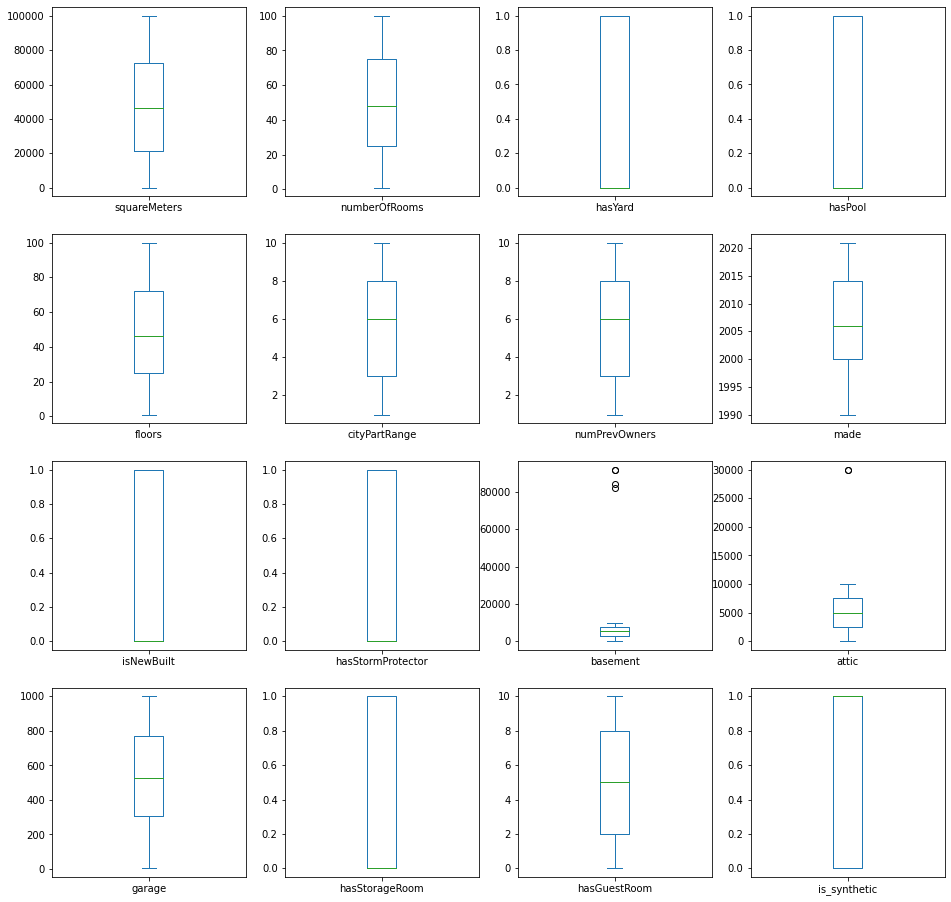

In [21]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

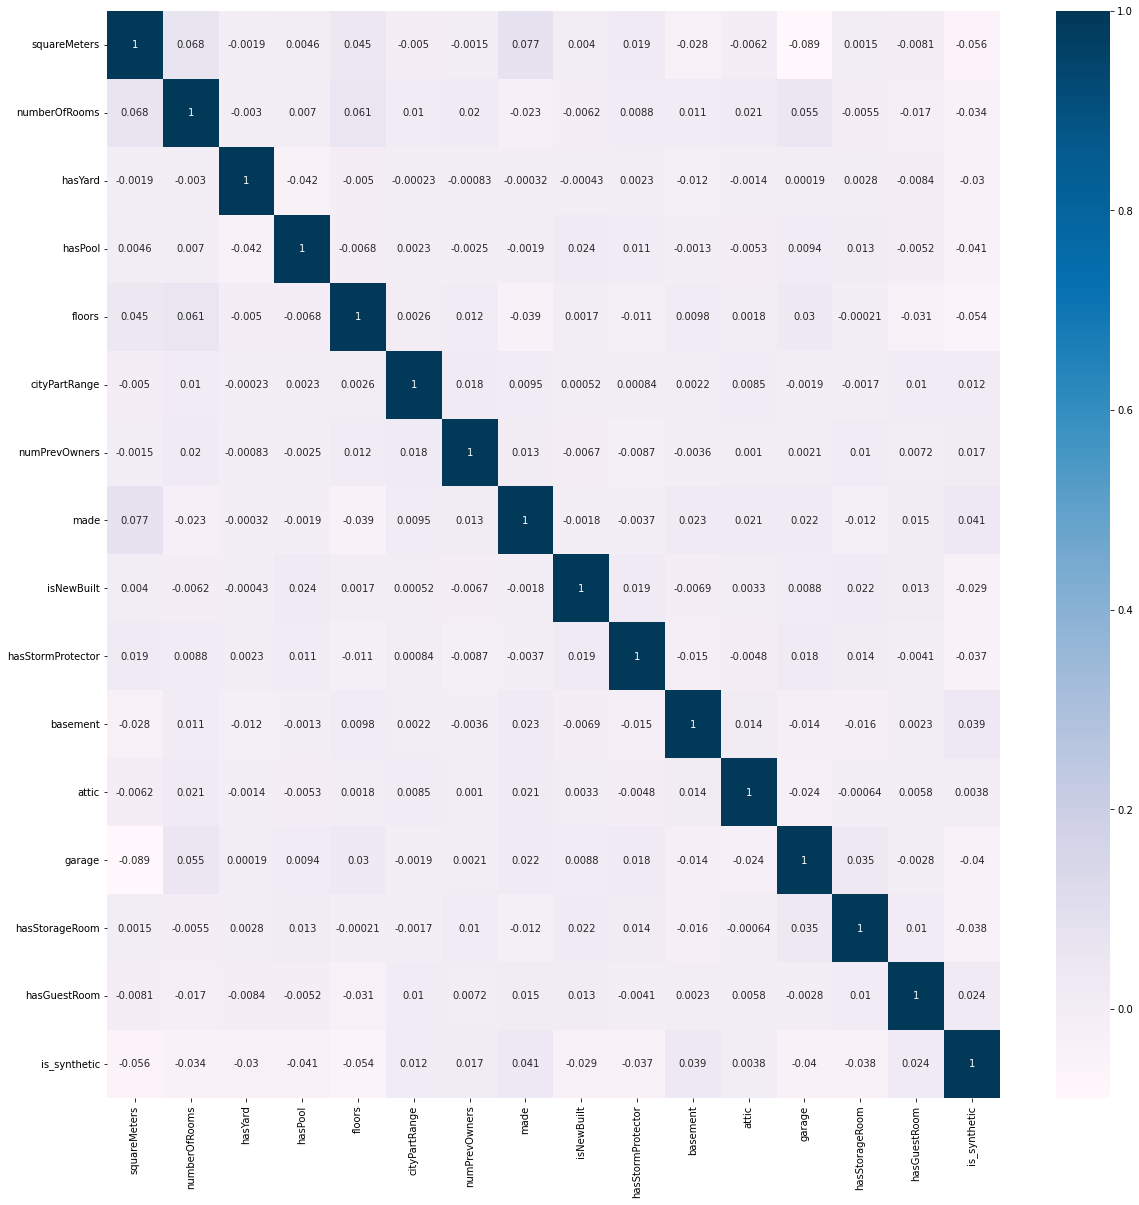

In [22]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [25]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 16
Number of categorical columns: 0
Total number of columns in the feature dataframe: 16


In [26]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

### 3.b) Training Data Balancing

In [27]:
# Not applicable for this iteration of modeling

### 3.c) Feature Selection

In [28]:
# Not applicable for this iteration of modeling

### 3.d) Display the Final Datasets for Model-Building

In [29]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (32715, 16) array_target_train.shape: (32715,)


In [30]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [31]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [32]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [33]:
train_models.append(('LNR', LinearRegression(n_jobs=N_JOBS)))
train_models.append(('ELN', ElasticNet(random_state=RNG_SEED)))
train_models.append(('CART', DecisionTreeRegressor(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [34]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LNR: -142751.837171 (58739.968619)
LinearRegression(n_jobs=2)
Model training time: 0:00:03.007126 



[Parallel(n_jobs=2)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ELN: -982604.528892 (7721.034718)
ElasticNet(random_state=888)
Model training time: 0:00:00.368252 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: -159808.668449 (61680.432451)
DecisionTreeRegressor(random_state=888)
Model training time: 0:00:08.061050 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: -1165416.802594 (18623.019594)
KNeighborsRegressor(n_jobs=2)
Model training time: 0:00:09.142044 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: -132505.372977 (50589.966963)
RandomForestRegressor(n_jobs=2, random_state=888)
Model training time: 0:03:03.679951 

EXT: -144652.655637 (42983.345789)
ExtraTreesRegressor(n_jobs=2, random_state=888)
Model training time: 0:01:53.620125 

Average metrics (neg_root_mean_squared_error) from all models: -454623.31095336215
Total training time for all models: 0:05:17.945608


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.9min finished


### 4.b) Spot-checking baseline algorithms

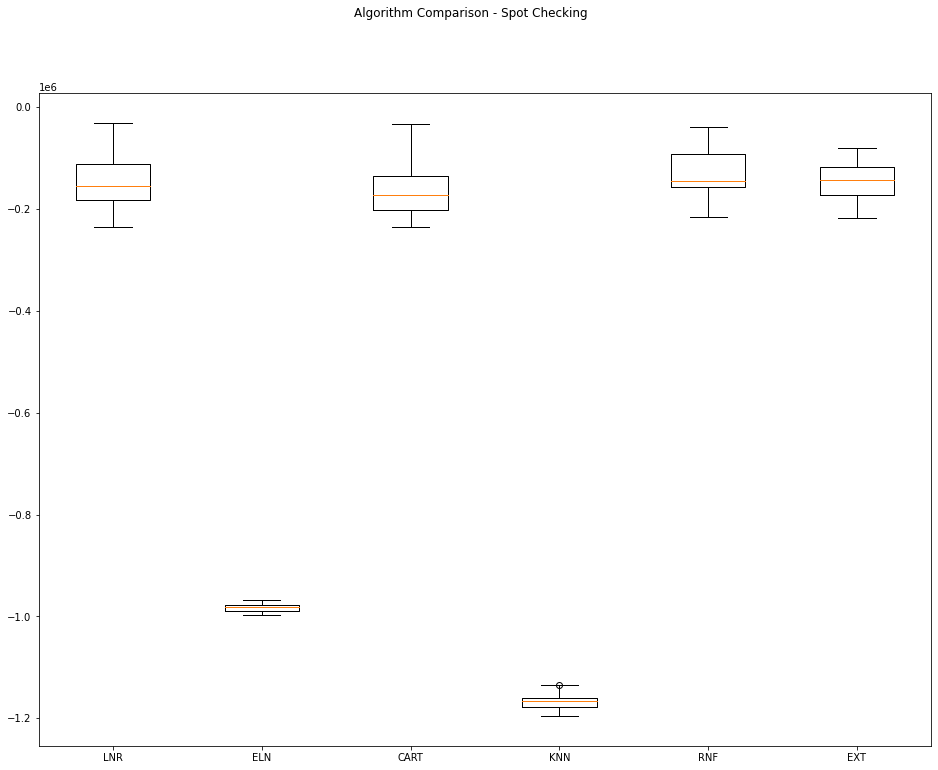

In [35]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [37]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [38]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = DecisionTreeRegressor(random_state=RNG_SEED)
tune_model_names.append('CART')
paramGrid1 = dict(criterion=np.array(['squared_error','friedman_mse','absolute_error','poisson']))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best: -141212.296539 using {'criterion': 'poisson'}
-159808.668449 (61680.432451) with: {'criterion': 'squared_error'}
-150637.264519 (77998.751364) with: {'criterion': 'friedman_mse'}
-181495.484287 (43499.838033) with: {'criterion': 'absolute_error'}
-141212.296539 (72917.020399) with: {'criterion': 'poisson'}
Model training time: 0:04:44.405859


In [39]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: criterion = poisson


In [40]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -132505.372977 using {'n_estimators': 100}
-132505.372977 (50589.966963) with: {'n_estimators': 100}
-133551.444412 (49688.476827) with: {'n_estimators': 300}
-133540.878785 (49129.628439) with: {'n_estimators': 500}
Model training time: 0:27:15.679028


In [41]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 4.d) Compare Algorithms After Tuning

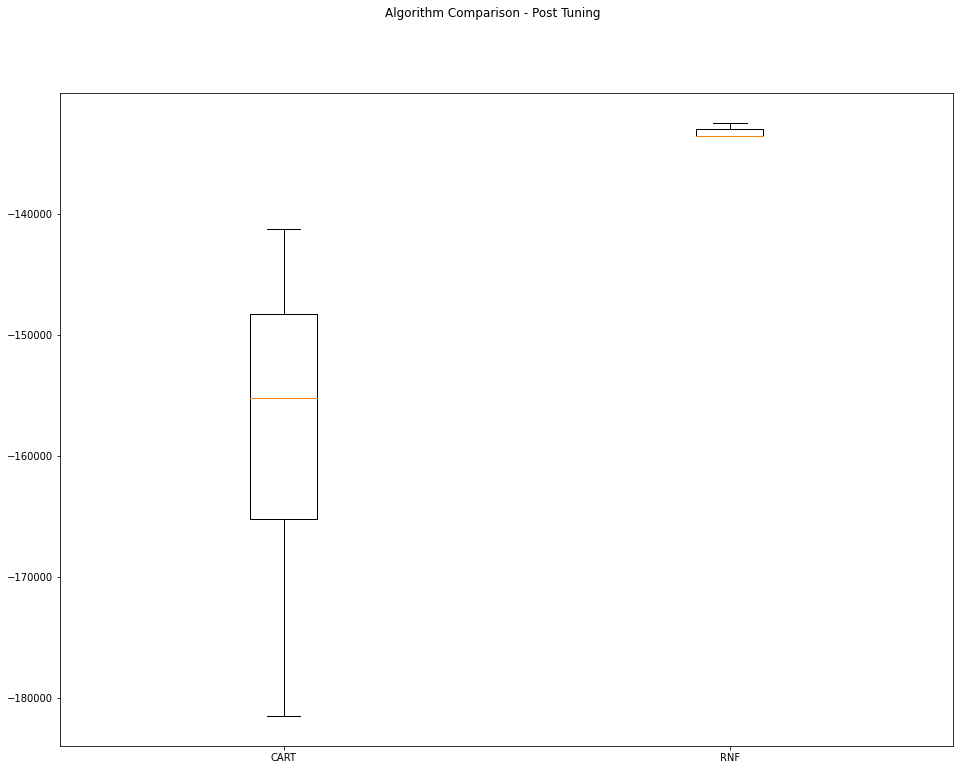

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [45]:
start_time_module = datetime.now()
FINAL_PARAMETER = best_paramValue2
final_model = RandomForestRegressor(n_estimators=FINAL_PARAMETER, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)
print ('Model training time:', (datetime.now() - start_time_module))

RandomForestRegressor(n_jobs=2, random_state=888)
Model training time: 0:00:20.316951


### 5.b) Load Test Dataset and Make Predictions

In [46]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Take a peek at the dataframe after import
print(df_features_test.head())

      id  squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0  22730         47580             89        0        1       8     54830   
1  22731         62083             38        0        0      87      8576   
2  22732         90499             75        1        1      37     62454   
3  22733         16354             47        1        1       9      9262   
4  22734         67510              8        0        0      55     24112   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              5              3  1995           0                  0   
1             10              3  1994           1                  1   
2              9              6  1997           0                  1   
3              6              5  2019           1                  1   
4              3              7  2014           1                  1   

   basement  attic  garage  hasStorageRoom  hasGuestRoom  is_synthetic  
0      6885   8181     241     

In [47]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

      id
0  22730
1  22731
2  22732
3  22733
4  22734


In [48]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,'cityCode'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   squareMeters  numberOfRooms  hasYard  hasPool  floors  cityPartRange  \
0         47580             89        0        1       8              5   
1         62083             38        0        0      87             10   
2         90499             75        1        1      37              9   
3         16354             47        1        1       9              6   
4         67510              8        0        0      55              3   

   numPrevOwners  made  isNewBuilt  hasStormProtector  basement  attic  \
0              3  1995           0                  0      6885   8181   
1              3  1994           1                  1      4601   9237   
2              6  1997           0                  1      7454   2680   
3              5  2019           1                  1       705   5097   
4              7  2014           1                  1      3715   7979   

   garage  hasStorageRoom  hasGuestRoom  is_synthetic  
0     241               0             8         

In [49]:
print(df_features_test.describe())

       squareMeters  numberOfRooms       hasYard       hasPool        floors  \
count  15154.000000   15154.000000  15154.000000  15154.000000  15154.000000   
mean   45729.407681      47.874951      0.483371      0.445361     46.401148   
std    29200.142520      28.164077      0.499740      0.497022     27.000547   
min       69.000000       1.000000      0.000000      0.000000      1.000000   
25%    19189.000000      25.000000      0.000000      0.000000     25.000000   
50%    43802.000000      46.000000      0.000000      0.000000     44.000000   
75%    70898.000000      75.000000      1.000000      1.000000     69.000000   
max    99999.000000     100.000000      1.000000      1.000000    100.000000   

       cityPartRange  numPrevOwners          made    isNewBuilt  \
count   15154.000000   15154.000000  15154.000000  15154.000000   
mean        5.616933       5.602547   2006.225485      0.472219   
std         2.727914       2.718316      8.156347      0.499244   
min        

In [50]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (15154, 16) to array_features_test.shape: (15154, 16)


In [51]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[4765679.693      6216313.62099999 9057656.21100002 ... 7361119.56899999
 7767254.23599999 1822890.73      ]


In [52]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

price


In [53]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

      id        price
0  22730  4765679.693
1  22731  6216313.621
2  22732  9057656.211
3  22733  1644761.061
4  22734  6758716.642


In [54]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_sklearn_20230313-1715.csv


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:37:47.408770
